<a href="https://colab.research.google.com/github/dric2018/zindiWheatChallenge/blob/master/zindiWheatChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
! nvidia-smi

Sun Aug 30 03:55:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import warnings

warnings.filterwarnings(action='ignore')

In [3]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torchsummary import summary
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchsummary import summary
from PIL import Image

import sklearn
from sklearn.metrics import roc_curve, auc, log_loss, precision_score, f1_score, recall_score, confusion_matrix

import matplotlib as mplb 
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd 

import seaborn as sns
import sys
from tensorflow.keras.utils import to_categorical
import os 
import zipfile
import shutil
from tqdm.notebook import tqdm

In [4]:
torch.__version__

'1.6.0+cu101'

# config

In [5]:
base_dir = '/content'
seed_val = 2020

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set seed 
np.random.seed(seed=seed_val)
torch.manual_seed(seed=seed_val)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed=seed_val)
    torch.cuda.manual_seed_all(seed=seed_val)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [6]:
device.type

'cuda'

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=.2),
        #transforms.RandomRotation(degrees=35),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [43]:
IMG_SIZE = 224
IMG_SHAPE  = (3, 224, 224)
BATCH_SIZE = 32
class_names = ['Crown_root', 'Tillering', "XXXXX", "Booting", "Heading", "Anthesis", "Milking"]

# Getting data

In [10]:
! curl "https://zindpublic.blob.core.windows.net/private/uploads/competition_datafile/file/674/Train.csv?sp=r&sv=2015-04-05&sr=b&st=2020-08-30T03"%"3A57"%"3A03Z&se=2020-08-30T04"%"3A13"%"3A03Z&sig=rtK68ONxD0y04OgUpMR05"%"2BlbqDMVTj5bJxYnT2ZZ8ak"%"3D" -H "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:79.0) Gecko/20100101 Firefox/79.0" -H "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8" -H "Accept-Language: fr,fr-FR;q=0.8,en-US;q=0.5,en;q=0.3" --compressed -H "Referer: https://zindi.africa/competitions/cgiar-wheat-growth-stage-challenge/data" -H "Connection: keep-alive" -H "Upgrade-Insecure-Requests: 1" -o Train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  135k  100  135k    0     0  87517      0  0:00:01  0:00:01 --:--:-- 87517


In [11]:
! curl "https://zindpublic.blob.core.windows.net/private/uploads/competition_datafile/file/673/SampleSubmission.csv?sp=r&sv=2015-04-05&sr=b&st=2020-08-30T03"%"3A57"%"3A31Z&se=2020-08-30T04"%"3A13"%"3A31Z&sig=HPoIucHcwV8JE8b9ScNGaegis"%"2FLx6osGfRQfrg34rbY"%"3D" -H "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:79.0) Gecko/20100101 Firefox/79.0" -H "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8" -H "Accept-Language: fr,fr-FR;q=0.8,en-US;q=0.5,en;q=0.3" --compressed -H "Referer: https://zindi.africa/competitions/cgiar-wheat-growth-stage-challenge/data" -H "Connection: keep-alive" -H "Upgrade-Insecure-Requests: 1" -o SampleSubmission.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39155  100 39155    0     0  33098      0  0:00:01  0:00:01 --:--:-- 33098


In [12]:
! curl "https://zindpublic.blob.core.windows.net/private/uploads/competition_datafile/file/675/Images.zip?sp=r&sv=2015-04-05&sr=b&st=2020-08-30T03"%"3A55"%"3A56Z&se=2020-08-30T04"%"3A11"%"3A56Z&sig=9fokH"%"2BuaGegmcXj5vSLQTQzbmQggcNPL9na7MsnoVS0"%"3D" -H "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:79.0) Gecko/20100101 Firefox/79.0" -H "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8" -H "Accept-Language: fr,fr-FR;q=0.8,en-US;q=0.5,en;q=0.3" --compressed -H "Referer: https://zindi.africa/competitions/cgiar-wheat-growth-stage-challenge/data" -H "Connection: keep-alive" -H "Upgrade-Insecure-Requests: 1" -o images.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  389M  100  389M    0     0  4951k      0  0:01:20  0:01:20 --:--:-- 3427k


In [13]:
train_csv_path = os.path.join(base_dir, "Train.csv")
sample_sub_path = os.path.join(base_dir, "SampleSubmission.csv")



train_df = pd.read_csv(train_csv_path)
sample_sub = pd.read_csv(sample_sub_path)

# Data management

In [14]:
train_df.head()

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1
2,1IYVvHwA,1,1
3,8OEdWwmU,1,1
4,oc5iO04j,1,1


In [15]:
train_df.describe()

,growth_stage,label_quality
count,10695.000000,10695.000000
mean,3.654137,1.267041
std,2.293861,0.442434
min,1.000000,1.000000
25%,1.000000,1.000000
50%,4.000000,1.000000
75%,6.000000,2.000000
max,7.000000,2.000000


In [16]:
sample_sub.head()

,UID,growth_stage
0,F3LbWkZq,0
1,6P4wLVzI,0
2,Tn6HIrdS,0
3,EYM5R1TK,0
4,fkcevlA0,0


In [17]:
train_images_list = train_df['UID'].to_list()
test_images_list = sample_sub['UID'].to_list()

len(train_images_list), len(test_images_list)

(10695, 3558)

In [44]:
! rm -r /content/dataset/Images

In [45]:
! rm -r /content/dataset/train &&  rm -r /content/dataset/test

In [46]:
! mkdir /content/dataset/train && mkdir /content/dataset/test

In [47]:
! mkdir /content/dataset/train/{class_names[0]} &&  mkdir /content/dataset/train/{class_names[1]} && mkdir /content/dataset/train/{class_names[2]} && mkdir /content/dataset/train/{class_names[3]} &&  mkdir /content/dataset/train/{class_names[4]} && mkdir /content/dataset/train/{class_names[5]} && mkdir /content/dataset/train/{class_names[6]}

In [48]:
train_images_dir =  os.path.join(base_dir, "dataset/train")
test_images_dir =  os.path.join(base_dir, "dataset/test")

In [31]:
train_df['growth_stage'].unique()

array([4, 1, 6, 3, 7, 2, 5])

In [32]:
train_df['growth_stage'].value_counts()

1    3057
7    2335
4    1712
2    1389
5    1092
3     689
6     421
Name: growth_stage, dtype: int64

In [23]:
def extract_images(dest="."):
  try:
    with zipfile.ZipFile(os.path.join(base_dir, "images.zip"), "r") as zipF:
      zipF.extractall(path=dest)
      print('[INFO] Done !')
  except Exception as ex:
    print(ex)

In [49]:
extract_images(dest=os.path.join(base_dir, "dataset/"))

[INFO] Done !


In [50]:
dataset_path = os.path.join(base_dir, 'dataset/Images')
for imag in tqdm(os.listdir(dataset_path), desc='Moving files into their specific folders'):
  img_path = os.path.join(dataset_path, imag)
  src = img_path
  
  try:
    label = train_df.loc[train_df['UID'] == imag.split('.')[0]]['growth_stage'].values[0]
    dest = os.path.join(train_images_dir, class_names[label-1])
    shutil.move(src, dest)

  except Exception as ex:
    dest = test_images_dir
    shutil.move(src, dest)
  

In [51]:
! ls /content/dataset/train/

Anthesis  Booting  Crown_root  Heading	Milking  Tillering  XXXXX


In [52]:
len(os.listdir(train_images_dir)), len(os.listdir(test_images_dir))

(7, 3558)

In [53]:
class ZindiWheatDataset(Dataset):
    def __init__(self, csv_path=train_csv_path, task='train', transform=None, num_classes=7):
        super(ZindiWheatDataset, self).__init__()
        self.csv_file = pd.read_csv(csv_path)
        self.task = task
        self.num_classes = num_classes
        self.transform = transform

    
    def __getitem__(self, index):
            
        img_name = self.csv_file.iloc[index, 0]+'.jpeg'
        try:
            if self.task=='train':
                img_array = Image.open(os.path.join(train_images_dir, img_name)).convert("RGB") 
                if self.transform is not None:
                    img_array = self.transform(img_array)
            else:
                img_array = Image.open(os.path.join(test_images_dir, img_name)).convert("RGB") 
                if self.transform is not None:
                    img_array = self.transform(img_array)
            
        except Exception as ex:
            print(f'[ERROR] {ex}')
        
        if self.task == 'train':
            label = torch.tensor(to_categorical(self.csv_file.iloc[index, 2], self.num_classes), dtype=torch.float)
            output =  (img_array, label)
        else:
            output =  img_array
            
        return output
    
    def __len__(self):
        return len(self.csv_file)

In [54]:
test_dataset = ZindiWheatDataset(csv_path=sample_sub_path, task='test', transform=data_transforms['test'], num_classes=7)

def target_to_one_hot(target):
    target = torch.tensor(to_categorical(target, num_classes=7), dtype=torch.float)
    return target 

#using pytorch based way 
train_set = ImageFolder(root=train_images_dir, 
                        transform=data_transforms['train'])
                        #target_transform=target_to_one_hot)
len(train_set), len(test_dataset)

(10695, 3558)

In [55]:
test_dataset[15].shape

torch.Size([3, 224, 224])

In [56]:
# Creating data indices for training and validation splits:
validation_split = 0.15
shuffle_dataset = True

dataset_size = len(train_set)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(seed_val)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

len(train_indices), len(val_indices)

(9091, 1604)

In [57]:
# dataloaders 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)

validation_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                                sampler=valid_sampler, shuffle=False)

test_data_loader = DataLoader(dataset=test_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False, 
                               num_workers=2)

In [58]:
# dataloaders 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)

validation_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                                sampler=valid_sampler, shuffle=False)

test_data_loader = DataLoader(dataset=test_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False, 
                               num_workers=2)

#Visualization

In [59]:
imgs, labs = next(iter(train_loader))

In [60]:
class_names[torch.argmax(labs[2]).item()]

'Crown_root'

In [61]:
def visualize_sample(From = train_loader):
    """Imshow for Tensor."""
    images, labels = next(iter(From))
    
    plt.figure(figsize=(18, 10))
    num_to_show = min(BATCH_SIZE, 25)
    for i in range(num_to_show):
        if num_to_show < 25:
            l, c = int(round(np.sqrt(BATCH_SIZE))), int(round(np.sqrt(BATCH_SIZE)))
            ax = plt.subplot(l, c, i + 1)
            img = images[i].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)    
            plt.imshow(img)
            #label = int(labels[i].item())
            label = torch.argmax(labels[i]).item()
            plt.title(class_names[label])
            plt.axis("off")
        else:
            ax = plt.subplot(5, 5, i + 1)
            img = images[i].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)    
            plt.imshow(img)
            #label = int(labels[i].item())
            label = torch.argmax(labels[i]).item()
            plt.title(class_names[label])
            plt.axis("off")
            

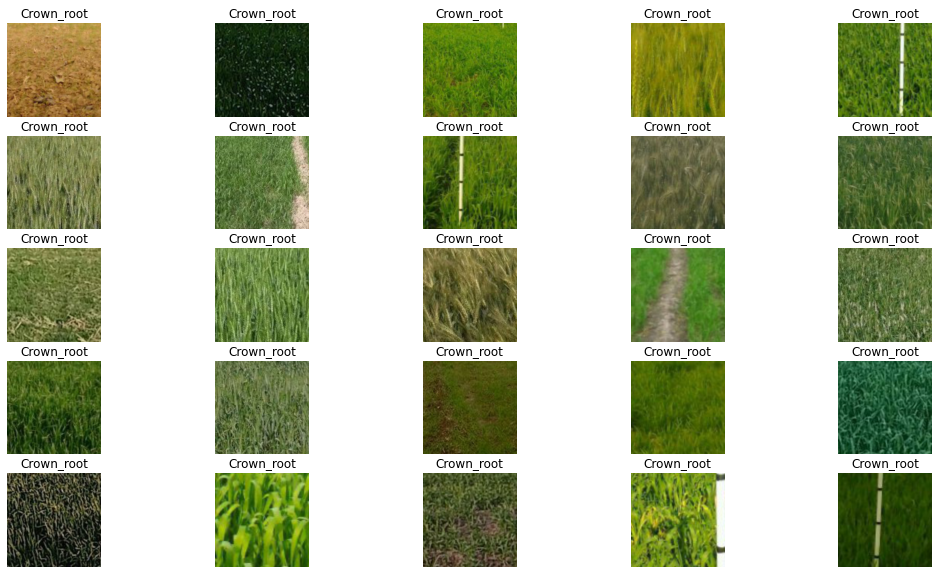

In [62]:
visualize_sample()

# Modeling

In [63]:
class MyModel(nn.Module):
    def __init__(self, based_on="", out_size=2, fc_size=512):
        super(MyModel, self).__init__()
        self.architecture_name = based_on
        self.archi = getattr(torchvision.models, self.architecture_name)(pretrained=True)
        
        for param in self.archi.parameters():
            param.requires_grad = False

        if "resnet" in self.architecture_name:
            self.classifier_name = "fc"
            self.num_ftrs_in = getattr(self.archi, self.classifier_name).in_features
        else:
            self.classifier_name = "classifier"
            self.num_ftrs_in = getattr(self.archi, self.classifier_name).in_features

        self.classifier = nn.Linear(in_features=self.num_ftrs_in, out_features=out_size)
    
        
        setattr(self.archi, self.classifier_name, self.classifier)
        torch.nn.init.xavier_normal_(getattr(getattr(self.archi, self.classifier_name), 'weight'))
        
        
    # forward pass
    def forward(self, x):
        x = self.archi(x.view(-1, 3, IMG_SIZE, IMG_SIZE))
        return x
        

In [64]:
architecture_name = "resnet50"

model = MyModel(based_on=architecture_name, out_size=7, fc_size=512)
model.to(device)
summary(model=model, input_size=IMG_SHAPE, device=device.type)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256

# Training pipeline

In [81]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase}"):
                inputs = inputs.to(device)
                labels = labels.squeeze(dim=1)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data[:, 1])
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model




def training_loop(model, epochs, train_loader, val_loader):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0
        train_accuracy = 0
        val_accuracy = 0

        # Training the model
        model.train()
        counter = 0
        for inputs, labels in tqdm(train_loader, desc=f"training | Epoch {epoch+1}/{epochs} "):
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Clear optimizers
            optimizer.zero_grad()
            # Forward pass
            output = model.forward(inputs)
            # Loss
            loss = criterion(output, labels)
            # Calculate gradients (backpropogation)
            loss.backward()
            # Adjust parameters based on gradients
            optimizer.step()
            # Add the loss to the training set's rnning loss
            train_loss += loss.item()*inputs.size(0)
            
            # Get the top class of the output
            # See how many of the classes were correct?
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            _, preds = torch.max(output.data, 1)
            train_accuracy += torch.sum(preds == labels.data)

        # Evaluating the model
        model.eval()
        counter = 0
        # Tell torch not to calculate gradients
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Validation | Epoch {epoch+1}/{epochs} "):
                # Move to device
                inputs, labels = inputs.to(device), labels.to(device)
                # Forward pass
                output = model.forward(inputs)
                # Calculate Loss
                valloss = criterion(output, labels)
                # Add loss to the validation set's running loss
                val_loss += valloss.item()*inputs.size(0)

  
                # See how many of the classes were correct?
                # Calculate the mean (get the accuracy for this batch)
                # and add it to the running accuracy for this epoch
                _, preds = torch.max(output.data, 1)
                val_accuracy += torch.sum(preds == labels.data)


        # Get the average loss for the entire epoch
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = val_loss/len(val_loader.dataset)
        # store results
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        
        # Print out the information
        print(f'\nTrain accuracy: {(train_accuracy/len(train_loader))*100:.6f}')
        print(f'Val accuracy: {(val_accuracy/len(val_loader))*100:.6f}')
        print('Training Loss: {:.6f} \tValidation Loss: {:.6f}\n'.format(train_loss, valid_loss))
        
        # save accuracies
        train_accs.append(train_accuracy/len(train_loader))
        val_accs.append(val_accuracy/len(val_loader))
        
    return model, train_losses, val_losses, train_accs, val_accs


def binary_acc(y_pred, y_test):
    
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)    
    correct_results_sum = (y_pred_tags == y_test).sum().float()    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)    
    return acc

In [69]:
outs = model(imgs.to(device))

In [70]:
outs.shape

torch.Size([32, 7])

In [71]:
labs.shape

torch.Size([32])

In [72]:
labs

tensor([2, 2, 4, 6, 0, 6, 2, 5, 6, 0, 1, 5, 0, 5, 0, 1, 5, 4, 5, 3, 3, 5, 1, 0,
        1, 2, 1, 2, 5, 2, 1, 4])

In [73]:
outs

tensor([[ 1.7194,  0.2687, -1.0077, -0.3384, -0.4572,  0.2042,  0.2607],
        [-0.3533,  0.2129, -0.3057,  0.1468, -0.1876,  0.1100,  0.2442],
        [ 0.5067,  1.4950,  0.1452,  0.0583, -0.7433,  0.2894,  1.3084],
        [ 1.3109,  1.7573, -0.2859, -0.7522,  0.6658,  0.0631, -0.2106],
        [ 1.0760,  1.3050, -0.3142, -0.7762,  0.8133,  0.1486,  0.5137],
        [ 1.0506,  1.0743,  0.3402, -0.1054,  0.4772,  0.1457,  0.5785],
        [ 0.8015,  0.6666, -0.6962, -0.5833,  0.0774, -0.6537,  1.1753],
        [ 0.5221,  0.4798,  0.3200, -0.3888, -0.3455, -0.0547,  0.0723],
        [ 0.7058,  0.5996,  0.0215,  0.2763, -0.0545,  0.3576,  0.0399],
        [-0.2762, -0.1226,  0.1867, -0.1384, -1.0359,  0.7846,  1.6633],
        [-0.2292,  0.0926, -0.0210, -0.1342,  0.7399,  0.3789, -0.3964],
        [ 0.3248,  0.5561, -0.9685, -0.3221,  0.6500, -0.2043, -0.2823],
        [ 0.7984,  0.0699, -0.2410, -0.0127, -0.1001,  0.1294, -0.2527],
        [ 0.2804,  0.0212,  0.4284, -0.4590, -0.351

# training params

In [75]:
learning_rate = 9.9e-5

#optimizer
optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate)

#loss
criterion = nn.CrossEntropyLoss()


In [76]:
criterion(outs, labs.to(device))

tensor(2.2043, device='cuda:0', grad_fn=<NllLossBackward>)

In [82]:
# train/eval
num_epochs = 15

model, train_losses, val_losses, train_accs, val_accs = training_loop(model=model, 
              epochs=num_epochs, 
              train_loader=train_loader, 
              val_loader=validation_loader)

RuntimeError: ignored

# Results

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, 'orange', label='validation loss')
plt.title("Losses results", size=16)
plt.xlabel("epoch")
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='training acc')
plt.plot(val_accs, 'orange', label='validation acc')
plt.title("Accuracies results", size=16)
plt.xlabel("epoch")
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Saving model

In [ ]:
# save model 
model_path = f'mask_{architecture_name}_based.pt'

torch.save(model.state_dict(),os.path.join(base_dir, , model_path))  

# Evaluation and submissions